In [11]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision.models as models
import torchvision.transforms as transforms

import numpy as np
import pandas as pd
import cv2
import os
import time
import psutil
from datetime import datetime, timedelta
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Configuração de reprodutibilidade
torch.manual_seed(42)
np.random.seed(42)

# Verifica GPU
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Usando: {device}")

if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"VRAM: {torch.cuda.get_device_properties(0).total_memory / 1024**3:.1f} GB")

Usando: cuda
GPU: NVIDIA GeForce RTX 2080
VRAM: 7.6 GB


In [15]:
# Configurações do experimento
IMG_SIZE = 224
BATCH_SIZE = 8
EPOCHS = 100
LEARNING_RATE = 0.001
VALIDATION_SPLIT = 0.3

BASE_PATH = r"../data/raw/RAF-DB/DATASET"

EMOTION_LABELS = {
    'Raiva': 0, 'Nojo': 1, 'Medo': 2, 'Felicidade': 3,
    'Neutro': 4, 'Tristeza': 5, 'Surpresa': 6
}

print(f"Configurações:")
print(f"- IMG_SIZE: {IMG_SIZE}")
print(f"- BATCH_SIZE: {BATCH_SIZE}")
print(f"- EPOCHS: {EPOCHS}")
print(f"- Device: {device}")

Configurações:
- IMG_SIZE: 224
- BATCH_SIZE: 8
- EPOCHS: 100
- Device: cuda


In [16]:
def load_data():
    """Carrega dados de imagens"""
    
    def load_from_dir(path, set_name):
        images, labels = [], []
        print(f"\nCarregando {set_name} de: {path}")
        
        if not os.path.exists(path):
            print(f"Erro: {path} não existe")
            return np.array([]), np.array([])
        
        for emotion, label in EMOTION_LABELS.items():
            emotion_path = os.path.join(path, emotion)
            if not os.path.exists(emotion_path):
                continue
            
            count = 0
            for img_file in os.listdir(emotion_path):
                if not img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                    continue
                
                try:
                    img = cv2.imread(os.path.join(emotion_path, img_file))
                    if img is None:
                        continue
                    
                    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                    img = cv2.resize(img, (IMG_SIZE, IMG_SIZE))
                    
                    if len(img.shape) == 2:
                        img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
                    
                    images.append(img)
                    labels.append(label)
                    count += 1
                except:
                    continue
            
            print(f"  {emotion}: {count} imagens")
        
        return np.array(images), np.array(labels)
    
    # Carrega train e test
    train_path = os.path.join(BASE_PATH, "train")
    test_path = os.path.join(BASE_PATH, "test")
    
    X_train, y_train = load_from_dir(train_path, "TREINO")
    X_test, y_test = load_from_dir(test_path, "TESTE")
    
    if len(X_train) == 0:
        print("Erro: Nenhum dado carregado!")
        return None, None, None, None
    
    # Normaliza [0, 255] -> [0, 1]
    X_train = X_train.astype(np.float32) / 255.0
    X_test = X_test.astype(np.float32) / 255.0
    
    print(f"\n✓ Dados carregados:")
    print(f"  Train: {X_train.shape}")
    print(f"  Test: {X_test.shape}")
    
    return X_train, y_train, X_test, y_test

# Carrega dados
X_train, y_train, X_test, y_test = load_data()


Carregando TREINO de: ../data/raw/RAF-DB/DATASET/train
  Raiva: 705 imagens
  Nojo: 717 imagens
  Medo: 281 imagens
  Felicidade: 4772 imagens
  Neutro: 2524 imagens
  Tristeza: 1982 imagens
  Surpresa: 1290 imagens

Carregando TESTE de: ../data/raw/RAF-DB/DATASET/test
  Raiva: 162 imagens
  Nojo: 160 imagens
  Medo: 74 imagens
  Felicidade: 1185 imagens
  Neutro: 680 imagens
  Tristeza: 478 imagens
  Surpresa: 329 imagens

✓ Dados carregados:
  Train: (12271, 224, 224, 3)
  Test: (3068, 224, 224, 3)


In [17]:
# Split train/validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train,
    test_size=VALIDATION_SPLIT,
    stratify=y_train,
    random_state=42
)

print(f"Split completo:")
print(f"  Train: {X_train_split.shape}")
print(f"  Val: {X_val.shape}")
print(f"  Test: {X_test.shape}")

# Converte para tensores PyTorch
# Formato: (N, H, W, C) -> (N, C, H, W) para PyTorch
X_train_tensor = torch.FloatTensor(X_train_split).permute(0, 3, 1, 2)
X_val_tensor = torch.FloatTensor(X_val).permute(0, 3, 1, 2)
X_test_tensor = torch.FloatTensor(X_test).permute(0, 3, 1, 2)

y_train_tensor = torch.LongTensor(y_train_split)
y_val_tensor = torch.LongTensor(y_val)
y_test_tensor = torch.LongTensor(y_test)

# Cria DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

print(f"\n✓ DataLoaders criados")
print(f"  Train batches: {len(train_loader)}")
print(f"  Val batches: {len(val_loader)}")
print(f"  Test batches: {len(test_loader)}")

Split completo:
  Train: (8589, 224, 224, 3)
  Val: (3682, 224, 224, 3)
  Test: (3068, 224, 224, 3)

✓ DataLoaders criados
  Train batches: 1074
  Val batches: 461
  Test batches: 384


In [18]:
class TrainingMonitor:
    """
    Classe para monitorar desempenho computacional durante o treinamento.
    Essencial para experimentos científicos reproduzíveis.
    """
    
    def __init__(self):
        self.start_time = None
        self.end_time = None
        self.peak_memory_mb = 0
        self.initial_memory_mb = 0
        self.process = psutil.Process()
        
    def start_monitoring(self):
        """Inicia o monitoramento de tempo e memória"""
        self.start_time = time.time()
        self.initial_memory_mb = self._get_memory_usage()
        self.peak_memory_mb = self.initial_memory_mb
        print(f"Iniciando treinamento ResNet50...")
        print(f"Horário de início: {time.strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"Memória inicial: {self.initial_memory_mb:.2f} MB")
        print("-" * 50)
        
    def _get_memory_usage(self):
        """Retorna uso atual de memória em MB"""
        return self.process.memory_info().rss / 1024 / 1024
        
    def update_peak_memory(self):
        """Atualiza o pico de memória se necessário"""
        current_memory = self._get_memory_usage()
        if current_memory > self.peak_memory_mb:
            self.peak_memory_mb = current_memory

# Instancia o monitor
monitor = TrainingMonitor()

In [19]:
class ResNet50Emotions(nn.Module):
    def __init__(self, num_classes=7):
        super(ResNet50Emotions, self).__init__()
        
        # Carrega ResNet50 pré-treinado
        self.resnet = models.resnet50(weights='IMAGENET1K_V1')
        
        # Congela camadas base
        for param in list(self.resnet.parameters())[:-20]:
            param.requires_grad = False
        
        # Substitui classificador
        num_features = self.resnet.fc.in_features
        self.resnet.fc = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(num_features, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 256),
            nn.ReLU(),
            nn.Linear(256, num_classes)
        )
    
    def forward(self, x):
        return self.resnet(x)

# Cria modelo
model = ResNet50Emotions(num_classes=7)
model = model.to(device)

total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f"\n✓ Modelo ResNet50 criado")
print(f"  Total params: {total_params:,}")
print(f"  Trainable: {trainable_params:,}")
print(f"  Device: {device}")

# Optimizer e Loss
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

print(f"\n✓ Optimizer: Adam (lr={LEARNING_RATE})")
print(f"✓ Loss: CrossEntropyLoss")

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/joao/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


100%|██████████| 97.8M/97.8M [00:13<00:00, 7.38MB/s]



✓ Modelo ResNet50 criado
  Total params: 24,690,247
  Trainable: 10,107,399
  Device: cuda

✓ Optimizer: Adam (lr=0.001)
✓ Loss: CrossEntropyLoss


In [20]:
def train_epoch(model, loader, criterion, optimizer, device):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0
    
    for inputs, labels in loader:
        inputs, labels = inputs.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()
    
    epoch_loss = running_loss / len(loader)
    epoch_acc = 100. * correct / total
    return epoch_loss, epoch_acc

def validate(model, loader, criterion, device):
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            
            running_loss += loss.item()
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()
    
    val_loss = running_loss / len(loader)
    val_acc = 100. * correct / total
    return val_loss, val_acc

# Treinamento
print("="*70)
print("INICIANDO TREINAMENTO")
print("="*70)

history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}
best_val_acc = 0
start_time = time.time()

for epoch in range(EPOCHS):
    train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_acc = validate(model, val_loader, criterion, device)
    
    history['train_loss'].append(train_loss)
    history['train_acc'].append(train_acc)
    history['val_loss'].append(val_loss)
    history['val_acc'].append(val_acc)
    
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), 'best_resnet50_model.pth')
    
    if epoch % 5 == 0:
        print(f'Epoch {epoch+1}/{EPOCHS}:')
        print(f'  Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

training_time = time.time() - start_time

print("="*70)
print("TREINAMENTO CONCLUÍDO")
print("="*70)
print(f"Tempo total: {timedelta(seconds=int(training_time))}")
print(f"Melhor Val Acc: {best_val_acc:.2f}%")

INICIANDO TREINAMENTO
Epoch 1/100:
  Train Loss: 1.4090, Train Acc: 49.10%
  Val Loss: 1.2862, Val Acc: 54.51%
Epoch 6/100:
  Train Loss: 0.7556, Train Acc: 74.01%
  Val Loss: 0.9145, Val Acc: 69.83%
Epoch 11/100:
  Train Loss: 0.4263, Train Acc: 85.03%
  Val Loss: 1.0674, Val Acc: 68.14%
Epoch 16/100:
  Train Loss: 0.2866, Train Acc: 90.56%
  Val Loss: 1.1579, Val Acc: 69.31%
Epoch 21/100:
  Train Loss: 0.1911, Train Acc: 93.82%
  Val Loss: 1.3415, Val Acc: 70.72%
Epoch 26/100:
  Train Loss: 0.1409, Train Acc: 95.28%
  Val Loss: 1.2555, Val Acc: 67.84%
Epoch 31/100:
  Train Loss: 0.1210, Train Acc: 96.22%
  Val Loss: 1.3982, Val Acc: 70.51%
Epoch 36/100:
  Train Loss: 0.0960, Train Acc: 97.11%
  Val Loss: 1.3268, Val Acc: 71.24%
Epoch 41/100:
  Train Loss: 0.0945, Train Acc: 97.14%
  Val Loss: 1.3085, Val Acc: 71.92%
Epoch 46/100:
  Train Loss: 0.0882, Train Acc: 97.26%
  Val Loss: 1.3871, Val Acc: 71.81%
Epoch 51/100:
  Train Loss: 0.0663, Train Acc: 98.35%
  Val Loss: 1.3154, Val Ac

In [21]:
# Carrega melhor modelo
model.load_state_dict(torch.load('best_resnet50_model.pth'))

# Avalia no teste
model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in test_loader:
        inputs = inputs.to(device)
        outputs = model(inputs)
        _, predicted = outputs.max(1)
        
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.numpy())

# Métricas
accuracy = accuracy_score(all_labels, all_preds)
conf_matrix = confusion_matrix(all_labels, all_preds)

print(f"\n{'='*70}")
print("RESULTADOS FINAIS")
print("="*70)
print(f"Test Accuracy: {accuracy*100:.2f}%")
print(f"\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=list(EMOTION_LABELS.keys())))


RESULTADOS FINAIS
Test Accuracy: 72.62%

Classification Report:
              precision    recall  f1-score   support

       Raiva       0.71      0.56      0.62       162
        Nojo       0.23      0.20      0.21       160
        Medo       0.60      0.50      0.54        74
  Felicidade       0.87      0.87      0.87      1185
      Neutro       0.64      0.73      0.68       680
    Tristeza       0.68      0.64      0.66       478
    Surpresa       0.72      0.70      0.71       329

    accuracy                           0.73      3068
   macro avg       0.63      0.60      0.61      3068
weighted avg       0.72      0.73      0.72      3068



In [23]:
# Célula: Função de Visualização Simplificada e Funcional
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import os

def create_visualization_simple(history, all_labels, all_preds, 
                                emotion_names, experiment_id, 
                                metrics=None, model_name="Model"):
    """
    Versão simplificada que funciona com dados básicos
    
    Args:
        history: dict com 'train_loss', 'train_acc', 'val_loss', 'val_acc'
        all_labels: lista/array com labels verdadeiros
        all_preds: lista/array com predições
        emotion_names: lista com nomes das emoções
        experiment_id: string com ID do experimento
        metrics: dict opcional com métricas extras
        model_name: nome do modelo
    """
    
    from sklearn.metrics import confusion_matrix, classification_report
    
    # Calcula métricas básicas
    conf_matrix = confusion_matrix(all_labels, all_preds)
    class_report = classification_report(all_labels, all_preds, 
                                        target_names=emotion_names, 
                                        output_dict=True)
    
    # Cria figura com 8 subplots (2x4)
    fig = plt.figure(figsize=(20, 10))
    
    # 1. Accuracy
    ax1 = plt.subplot(2, 4, 1)
    epochs = range(1, len(history['train_acc']) + 1)
    plt.plot(epochs, history['train_acc'], 'b-', linewidth=2, label='Train')
    plt.plot(epochs, history['val_acc'], 'r--', linewidth=2, label='Validation')
    plt.title(f'{model_name}: Accuracy', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy (%)')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 2. Loss
    ax2 = plt.subplot(2, 4, 2)
    plt.plot(epochs, history['train_loss'], 'b-', linewidth=2, label='Train')
    plt.plot(epochs, history['val_loss'], 'r--', linewidth=2, label='Validation')
    plt.title(f'{model_name}: Loss', fontsize=14, fontweight='bold')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Confusion Matrix
    ax3 = plt.subplot(2, 4, 3)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues',
                xticklabels=emotion_names, yticklabels=emotion_names, ax=ax3)
    plt.title('Confusion Matrix', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    
    # 4. Confusion Matrix Normalizada
    ax4 = plt.subplot(2, 4, 4)
    conf_matrix_norm = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    conf_matrix_norm = np.nan_to_num(conf_matrix_norm)
    sns.heatmap(conf_matrix_norm, annot=True, fmt='.2f', cmap='Greens',
                xticklabels=emotion_names, yticklabels=emotion_names, ax=ax4)
    plt.title('Confusion Matrix (Normalized)', fontsize=14, fontweight='bold')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.xticks(rotation=45, ha='right')
    
    # 5. Distribuição de Classes
    ax5 = plt.subplot(2, 4, 5)
    unique, counts = np.unique(all_labels, return_counts=True)
    class_counts = [counts[i] if i < len(counts) else 0 for i in range(len(emotion_names))]
    
    colors = plt.cm.Set3(np.linspace(0, 1, len(emotion_names)))
    bars = plt.bar(emotion_names, class_counts, color=colors, alpha=0.8, edgecolor='black')
    plt.title('Class Distribution', fontsize=14, fontweight='bold')
    plt.ylabel('Number of Samples')
    plt.xticks(rotation=45, ha='right')
    
    for bar, count in zip(bars, class_counts):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 5,
                f'{count}', ha='center', va='bottom', fontweight='bold')
    
    # 6. F1-Score por classe
    ax6 = plt.subplot(2, 4, 6)
    f1_scores = [class_report[emotion]['f1-score'] for emotion in emotion_names]
    bars = plt.bar(emotion_names, f1_scores, color='skyblue', alpha=0.8, edgecolor='navy')
    plt.title('F1-Score per Emotion', fontsize=14, fontweight='bold')
    plt.ylabel('F1-Score')
    plt.ylim(0, 1)
    plt.xticks(rotation=45, ha='right')
    
    for bar, score in zip(bars, f1_scores):
        plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.02,
                f'{score:.3f}', ha='center', va='bottom')
    
    # 7. Precision, Recall, F1
    ax7 = plt.subplot(2, 4, 7)
    precision_scores = [class_report[emotion]['precision'] for emotion in emotion_names]
    recall_scores = [class_report[emotion]['recall'] for emotion in emotion_names]
    
    x = np.arange(len(emotion_names))
    width = 0.25
    
    plt.bar(x - width, precision_scores, width, label='Precision', alpha=0.8, color='lightcoral')
    plt.bar(x, recall_scores, width, label='Recall', alpha=0.8, color='lightblue')
    plt.bar(x + width, f1_scores, width, label='F1', alpha=0.8, color='lightgreen')
    
    plt.title('Metrics per Class', fontsize=14, fontweight='bold')
    plt.ylabel('Score')
    plt.xticks(x, emotion_names, rotation=45, ha='right')
    plt.legend()
    plt.ylim(0, 1)
    
    # 8. Resumo
    ax8 = plt.subplot(2, 4, 8)
    ax8.axis('off')
    
    # Calcula métricas gerais
    from sklearn.metrics import accuracy_score
    accuracy = accuracy_score(all_labels, all_preds)
    precision_macro, recall_macro, f1_macro, _ = precision_recall_fscore_support(
        all_labels, all_preds, average='macro', zero_division=0)
    
    summary = f"""
{model_name.upper()} - RESULTS

Test Accuracy: {accuracy:.4f}
F1-Score (Macro): {f1_macro:.4f}
Precision (Macro): {precision_macro:.4f}
Recall (Macro): {recall_macro:.4f}

Epochs Trained: {len(history['train_acc'])}
Best Val Acc: {max(history['val_acc']):.2f}%

Classes: {len(emotion_names)}
Test Samples: {len(all_labels)}
    """
    
    if metrics:
        if 'training_time_seconds' in metrics:
            from datetime import timedelta
            time_str = str(timedelta(seconds=int(metrics['training_time_seconds'])))
            summary += f"\nTraining Time: {time_str}"
        if 'total_parameters' in metrics:
            params_m = metrics['total_parameters'] / 1_000_000
            summary += f"\nParameters: {params_m:.1f}M"
    
    ax8.text(0.1, 0.9, summary, transform=ax8.transAxes,
            fontsize=11, verticalalignment='top', family='monospace',
            bbox=dict(boxstyle='round', facecolor='lightblue', alpha=0.8))
    
    plt.tight_layout()
    
    # Salva
    os.makedirs('plots', exist_ok=True)
    plot_path = f'plots/results_{experiment_id}.png'
    plt.savefig(plot_path, dpi=300, bbox_inches='tight')
    print(f"\n✓ Visualization saved: {plot_path}")
    plt.show()
    
    # Print resumo textual
    print("\n" + "="*70)
    print(f"{model_name.upper()} - DETAILED RESULTS")
    print("="*70)
    print(f"\nOverall Performance:")
    print(f"  • Test Accuracy: {accuracy:.4f} ({accuracy*100:.2f}%)")
    print(f"  • F1-Score (Macro): {f1_macro:.4f}")
    print(f"  • Precision (Macro): {precision_macro:.4f}")
    print(f"  • Recall (Macro): {recall_macro:.4f}")
    
    print(f"\nPer-Class F1-Scores:")
    for emotion, f1 in zip(emotion_names, f1_scores):
        print(f"  • {emotion}: {f1:.4f}")
    
    print("="*70)

print("✓ Simple visualization function loaded")

✓ Simple visualization function loaded



✓ Visualization saved: plots/results_resnet50_emotion_20251007_192456.png


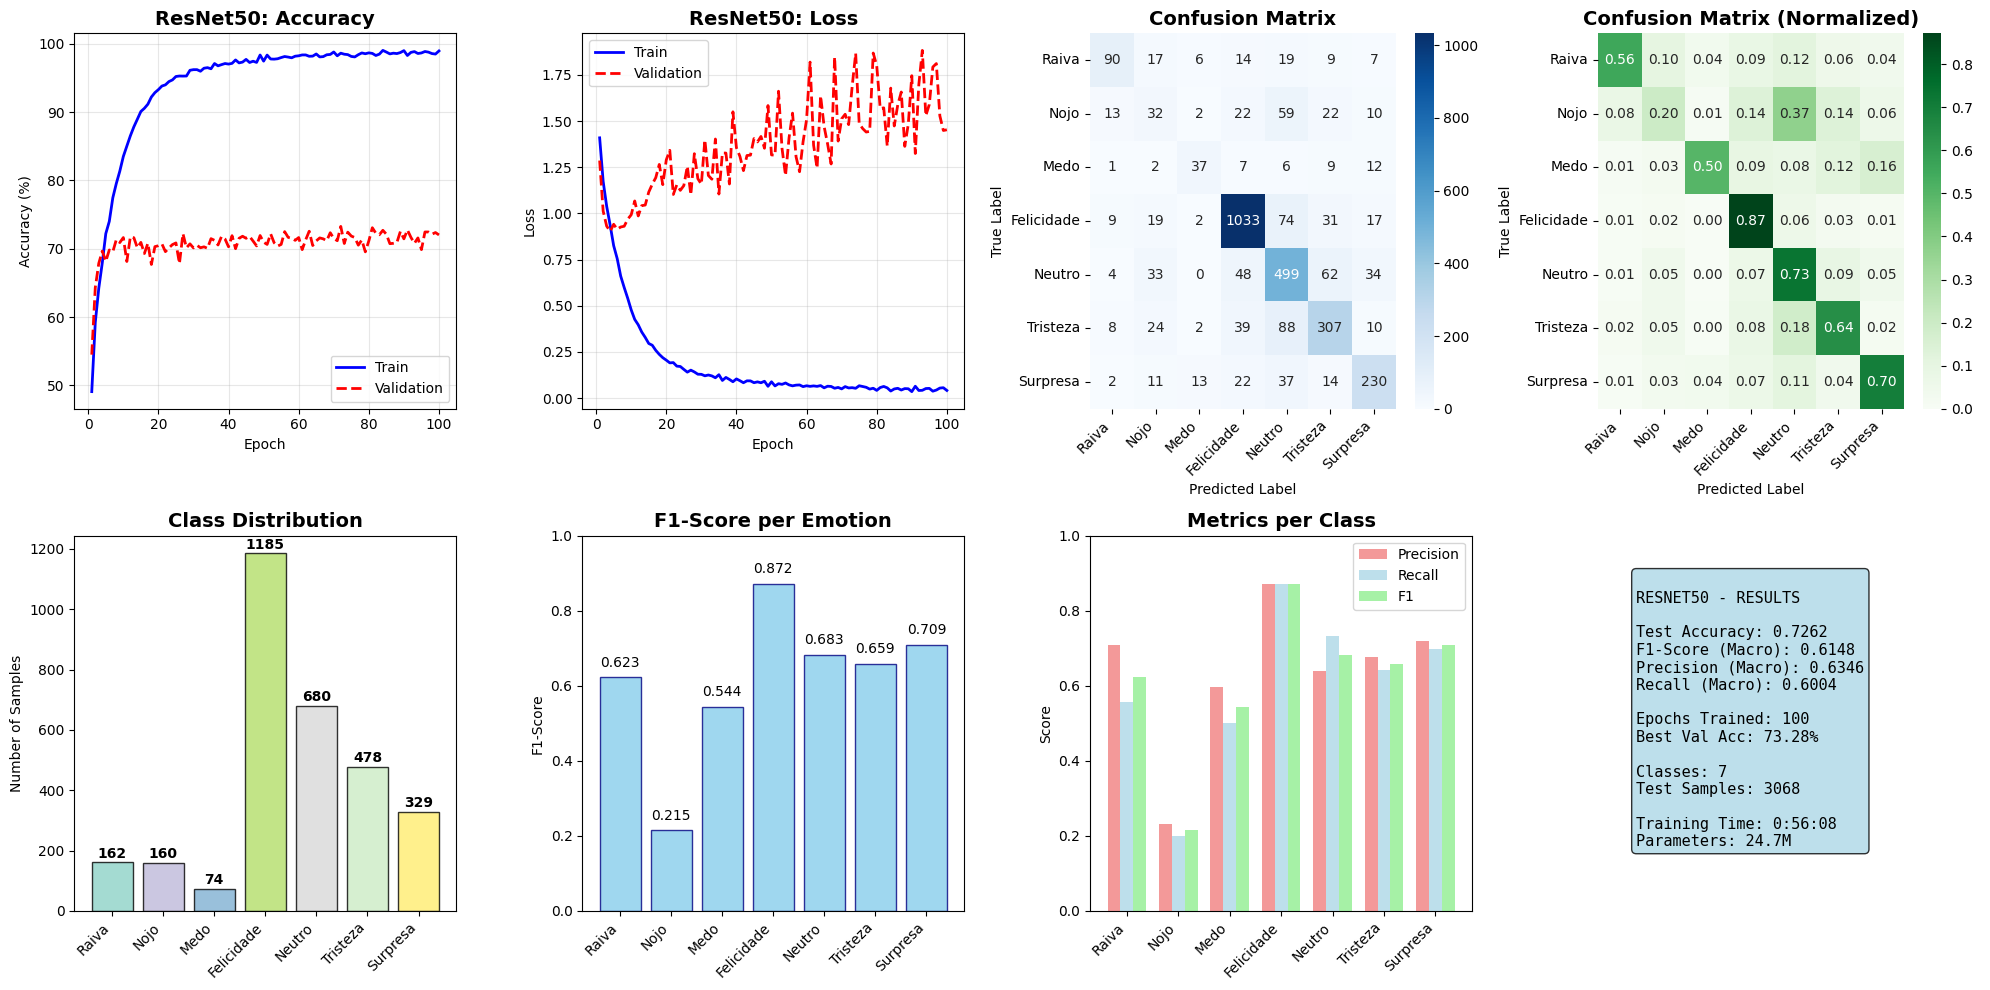


RESNET50 - DETAILED RESULTS

Overall Performance:
  • Test Accuracy: 0.7262 (72.62%)
  • F1-Score (Macro): 0.6148
  • Precision (Macro): 0.6346
  • Recall (Macro): 0.6004

Per-Class F1-Scores:
  • Raiva: 0.6228
  • Nojo: 0.2148
  • Medo: 0.5441
  • Felicidade: 0.8717
  • Neutro: 0.6826
  • Tristeza: 0.6588
  • Surpresa: 0.7088


In [24]:
# Célula 8: Gerar Visualizações
emotion_names = list(EMOTION_LABELS.keys())

# Prepara métricas opcionais (se disponível)
metrics_dict = {
    'training_time_seconds': training_time,  # do seu código de treinamento
    'total_parameters': total_params,
    'test_accuracy': accuracy
}

# Gera visualização
create_visualization_simple(
    history=history,
    all_labels=all_labels,
    all_preds=all_preds,
    emotion_names=emotion_names,
    experiment_id=experiment_id,
    metrics=metrics_dict,
    model_name="ResNet50"
)